In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import glob
import os
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt

In [2]:
def load_cmip_temp(scenario='historical', model='GFDL-ESM4', data_path='.', unit='C'):
    temp_series = pd.Series(dtype=np.float64)
    glob_path = os.path.join(data_path, 'near_surface_air_temperature', scenario, model, '*')
    
    for f in glob.glob(glob_path):
        data = Dataset(f, 'r', format='NETCDF4')
        start, end = f.split('/')[-1].split('.')[0].split('_')[-2:]
        tas = np.average(data['tas'], weights=np.cos(np.radians(data['lat'])), axis=1).mean(axis=-1)
        index = pd.to_datetime(start) + pd.to_timedelta(np.array(data['time']), unit='d')
        temp_series = temp_series.append(pd.Series(tas, index=index))
        
    if unit == 'C':
        temp_series = temp_series - 273.15
    elif unit != 'K':
        raise ValueError(f'Unsupported temperature unit "{unit}". Choose from [C, K]')
    return temp_series

In [3]:
new_recent = pd.read_csv('recent_tolledaten.csv', index_col=0)
new_recent.index = new_recent.index.astype(int)
new_recent = new_recent.groupby(new_recent.index).mean()
new_recent['T'] += 13.9
new_recent.head()

,T,gsl (mm),CO2 [ppmv]
1880,13.795000,-78.234677,290.940476
1881,13.805385,-70.678826,291.555556
1882,13.763077,-82.428044,292.107692
1883,13.678462,-72.177368,292.557692
1884,13.634615,-61.008497,293.007692


<AxesSubplot:xlabel='year'>

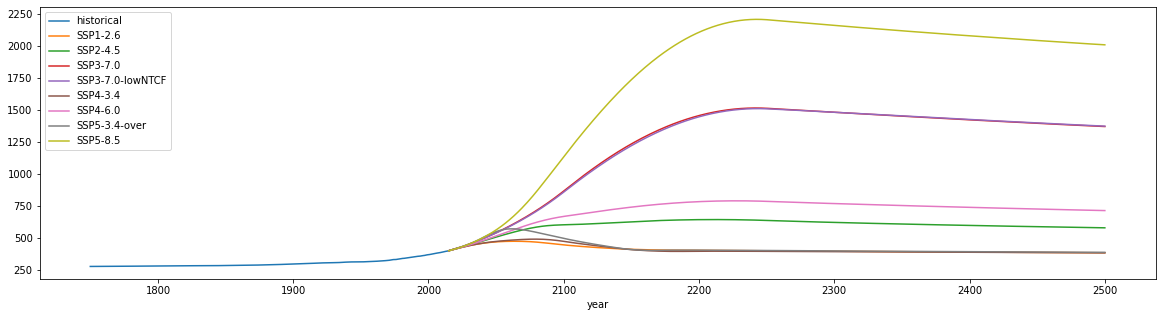

In [4]:
historical = pd.read_csv('CO2_pathways/historical_CO2_1750_2014.csv', index_col=0)
pred = pd.read_csv('CO2_pathways/co_pred_t4-11.csv', index_col=0)

plt.figure(figsize=(20, 5))
ax = plt.subplot()
historical.plot(ax=ax)
pred.plot(ax=ax)

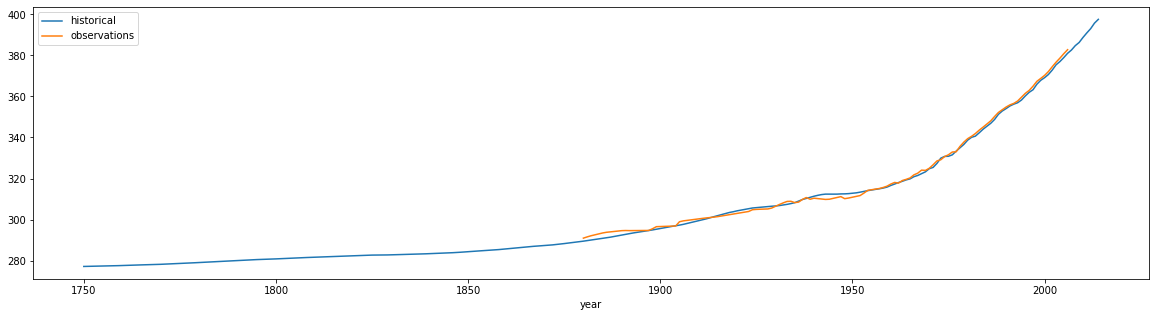

In [5]:
historical.plot(figsize=(20, 5))
new_recent['CO2 [ppmv]'].plot(label='observations')
plt.legend()

In [6]:
hist_temp = load_cmip_temp()
hist_temp = hist_temp.groupby(hist_temp.index.year).mean()

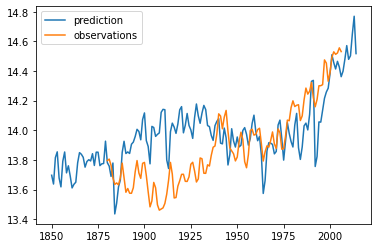

In [7]:
hist_temp.plot(label='prediction')
new_recent['T'].plot(label='observations')
plt.legend()

In [8]:
new_recent.head()

,T,gsl (mm),CO2 [ppmv]
1880,13.795000,-78.234677,290.940476
1881,13.805385,-70.678826,291.555556
1882,13.763077,-82.428044,292.107692
1883,13.678462,-72.177368,292.557692
1884,13.634615,-61.008497,293.007692


# train model

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [10]:
df = new_recent.copy()

train_size = 0.8
chunk_size = 1
label = 'gsl (mm) '
features = df.columns.drop(label)

def chunk(df, chunk_size=5):
    x = []
    index = []
    for i in range(chunk_size, len(df)):
        x.append(df.iloc[i-chunk_size:i].values.flatten())
        index.append(df.index[i])
    return np.array(x), np.array(index)

x, index = chunk(df[features], chunk_size=chunk_size)
y = df[label].iloc[chunk_size:]

split = int(len(x) * train_size)
x_train = x[:split]
y_train = y[:split]
index_train = index[:split]
x_test = x[split:]
y_test = y[split:]
index_test = index[split:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

/home/philipp/Python/sandbox/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9622586683823833 -0.9020772832914566


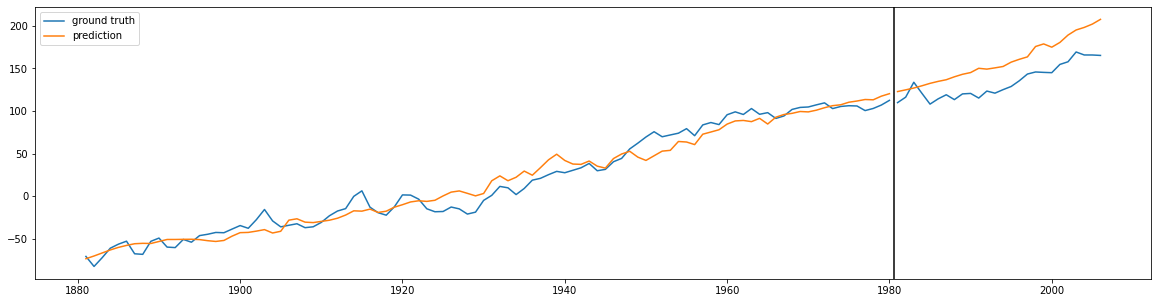

In [11]:
model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=10000)
model.fit(x_train, y_train)
print(model.score(x_train, y_train), model.score(x_test, y_test))

plt.figure(figsize=(20, 5))
plt.plot(index_train, y_train, c='C0', label='ground truth')
plt.plot(index_train, model.predict(x_train), c='C1', label='prediction')

plt.plot(index_test, y_test, c='C0')
plt.plot(index_test, model.predict(x_test), c='C1')

plt.axvline((index_train[-1] + index_test[0]) / 2, c='black')
plt.legend()
plt.show()

# train many models

In [ ]:
from tqdm.notebook import  tqdm
from joblib import Parallel, delayed

def train(x_train, y_train, x_test, y_test):
    model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=10000)
    model.fit(x_train, y_train)
    return model, model.score(x_test, y_test)

result = Parallel(n_jobs=-1)(delayed(train)(x_train, y_train, x_test, y_test) for _ in tqdm(range(100)))
models, scores = zip(*result)

In [ ]:
score_threshold = 0
scores = np.array(scores)
f'{(scores > score_threshold).sum()} models ({(scores > score_threshold).sum() / len(scores):.2%})'

In [ ]:
import pickle
import time

for i in np.argwhere(scores > score_threshold)[:,0]:
    with open(f'models/{time.time()}-{scores[i]:.4f}.pkl', 'wb') as f:
        pickle.dump(models[i], f)

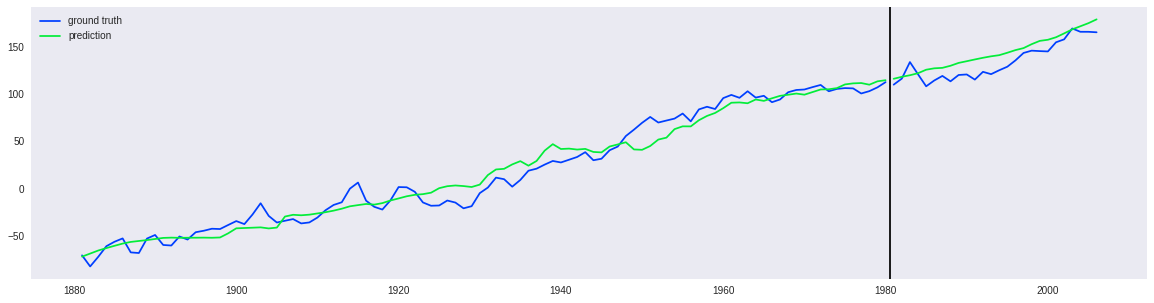

In [91]:
train_prediction = np.array([m.predict(x_train) for m, s in zip(models, scores) if s > 0])
test_prediction = np.array([m.predict(x_test) for m, s in zip(models, scores) if s > 0])

plt.figure(figsize=(20, 5))
plt.plot(index_train, y_train, c='C0', label='ground truth')
plt.plot(index_train, train_prediction.mean(axis=0), c='C1', label='prediction')

plt.plot(index_test, y_test, c='C0')
plt.plot(index_test, test_prediction.mean(axis=0), c='C1')

plt.axvline((index_train[-1] + index_test[0]) / 2, c='black')
plt.legend()
plt.show()

# CMIP sea level prediction (THIS IS THE IMPORTANT ONE)

In [23]:
temp_scenarios = ['ssp126', 'ssp370', 'ssp585']
for s in temp_scenarios:
    load_cmip_temp(scenario=s).to_csv(f'CMIP-{s}.csv')

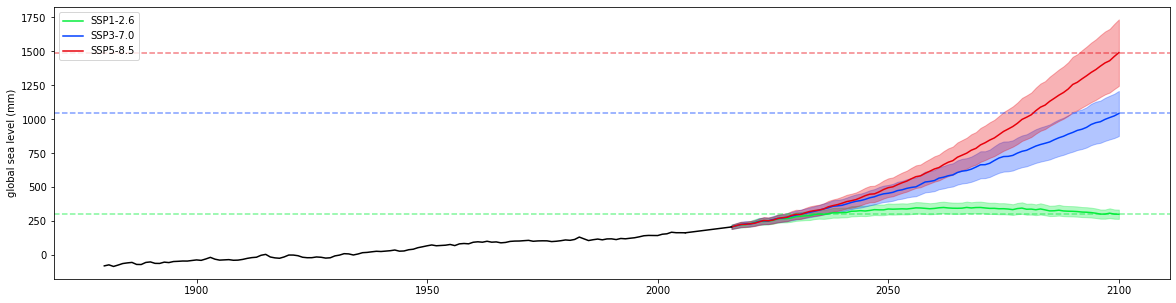

In [28]:
co2_scenarios = ['SSP1-2.6', 'SSP3-7.0', 'SSP5-8.5']

plt.style.use('seaborn-bright')

plt.figure(figsize=(20, 5))
plt.plot(new_recent['gsl (mm) '], color='0')
for i, (s_co2, s_temp) in enumerate(zip(co2_scenarios, temp_scenarios)):
    co2_pred = pred[s_co2]
    temp_pred = pd.read_csv(f'CMIP-{s_temp}.csv', index_col=0, parse_dates=True).iloc[:,0]
    temp_pred = temp_pred.groupby(temp_pred.index.year).mean()
    temp_pred.name = 'T'
    
    df_cmip = pd.DataFrame([temp_pred, co2_pred]).T.dropna()
    x, index = chunk(df_cmip, chunk_size=chunk_size)
    x = scaler.transform(x)
    
    prediction = np.array([m.predict(x) for m, s in zip(models, scores) if s > score_threshold])
    mean = prediction.mean(axis=0)
    err = prediction.std(axis=0)
    
    if i == 0:
        col = 'C1'
    elif i == 1:
        col = 'C0'
    elif i == 2:
        col = 'C2'
    plt.plot(index, mean, label=s_co2, color=col)
    plt.fill_between(index, mean - err, mean + err, alpha=0.3, color=col)
    plt.axhline(mean[-1], linestyle='--', color=col, alpha=0.5)

plt.plot([new_recent.index[-1], index[0]], [new_recent['gsl (mm) '].iloc[-1], mean[0]], color='0')

plt.ylabel('global sea level (mm)')
plt.legend(loc=2)
plt.savefig('CMIP_projection.png', transparent=True)

# 800k data

In [85]:
long = pd.read_csv('tolledaten.csv', index_col=0).iloc[::-1]
long_features = ['Ts (C)', 'CO2 (ppmv)']
long_label = ['SeaLev_longPC1']

x, index = chunk(long[long_features], chunk_size=chunk_size)
y = long[long_label].iloc[chunk_size:].values[:,0]

split = int(len(x) * train_size)
x_train = x[:split]
y_train = y[:split]

index_train = index[:split]
x_test = x[split:]
y_test = y[split:]
index_test = index[split:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

0.839037794873755 0.931398045721903


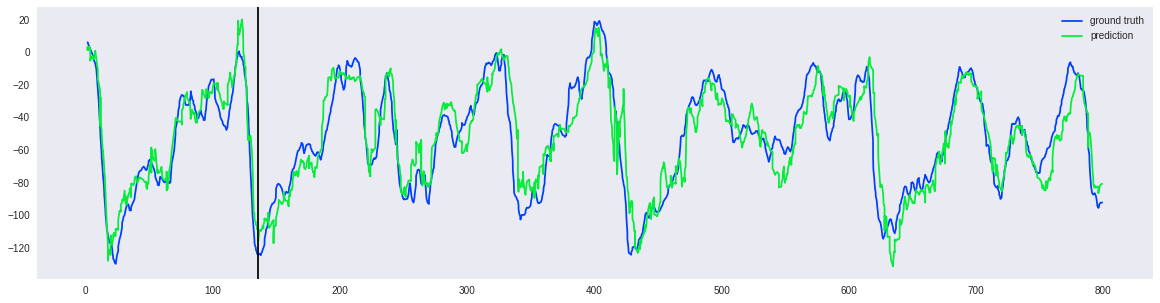

In [86]:
model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=10000)
model.fit(x_train, y_train)
print(model.score(x_train, y_train), model.score(x_test, y_test))

plt.figure(figsize=(20, 5))
plt.plot(index_train, y_train, c='C0', label='ground truth')
plt.plot(index_train, model.predict(x_train), c='C1', label='prediction')

plt.plot(index_test, y_test, c='C0')
plt.plot(index_test, model.predict(x_test), c='C1')

plt.axvline((index_train[-1] + index_test[0]) / 2, c='black')
plt.legend()
plt.show()

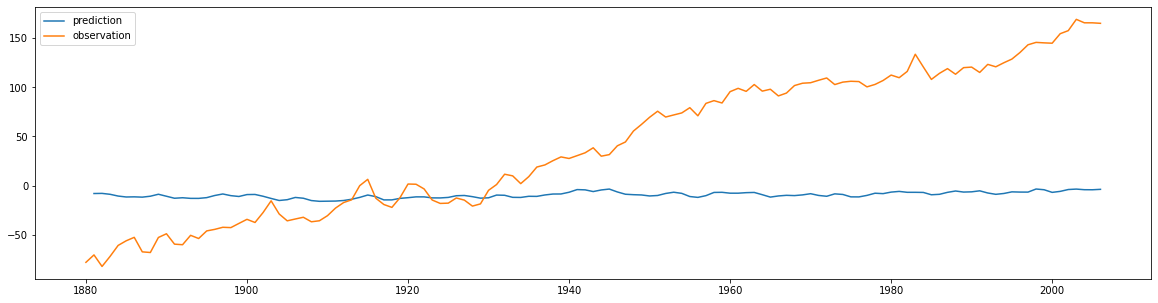

In [18]:
x, index = chunk(df[features], chunk_size=chunk_size)
x = scaler.transform(x)

plt.figure(figsize=(20, 5))
plt.plot(index, model.predict(x), label='prediction')
plt.plot(df[label], label='observation')
plt.legend()